In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import STL

In [4]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW','Datetime1'],inplace=True)
df1.head()

,unique_id,ds,y
0,h1,2022-01-04 00:00:00,20.867
1,h1,2022-01-04 01:00:00,21.000
2,h1,2022-01-04 02:00:00,20.867
3,h1,2022-01-04 03:00:00,20.650
4,h1,2022-01-04 04:00:00,20.400


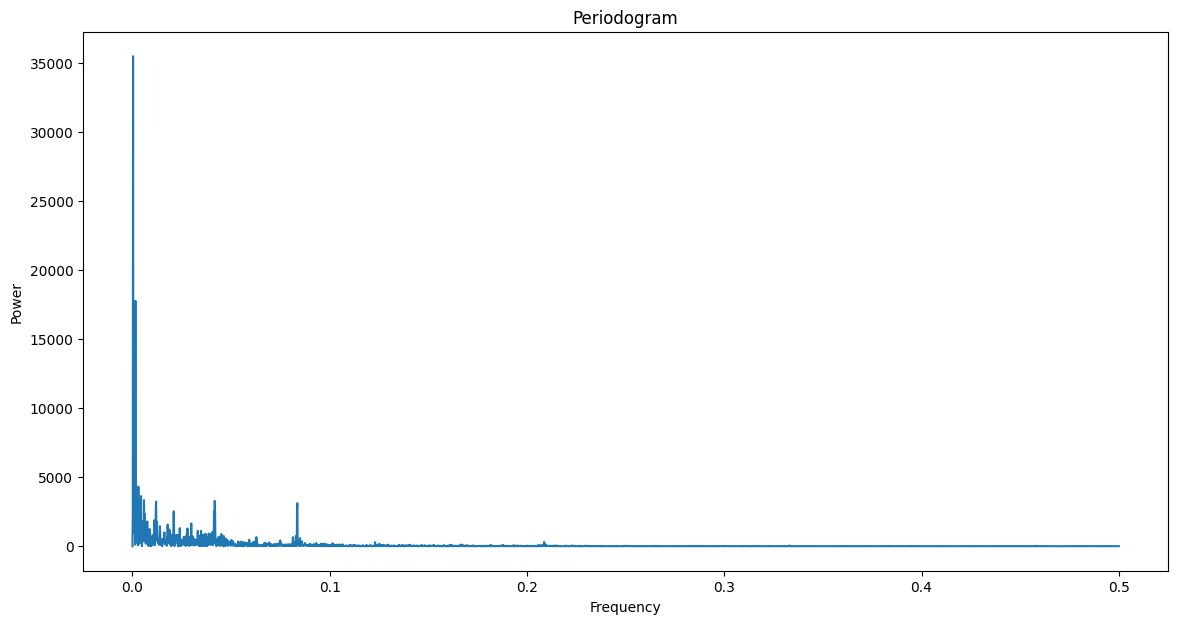

In [19]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df1['y'])
plt.figure(figsize=(14, 7))
plt.plot(frequencies, spectrum)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [20]:
max_idx = np.argmax(spectrum)
second_max_idx = np.argsort(spectrum)[-2]  # Get the second largest index

# Get the maximum and second maximum values
max_value = spectrum[max_idx]
second_max_value = spectrum[second_max_idx]

# Get the corresponding frequencies
max_freq = frequencies[max_idx]
second_max_freq = frequencies[second_max_idx]

In [21]:
max_freq, second_max_freq

(np.float64(0.0002995805871779509), np.float64(0.0014979029358897543))

In [22]:
1/max_freq, 1/second_max_freq

(np.float64(3338.0), np.float64(667.6))

In [33]:
seasonal_period=3338

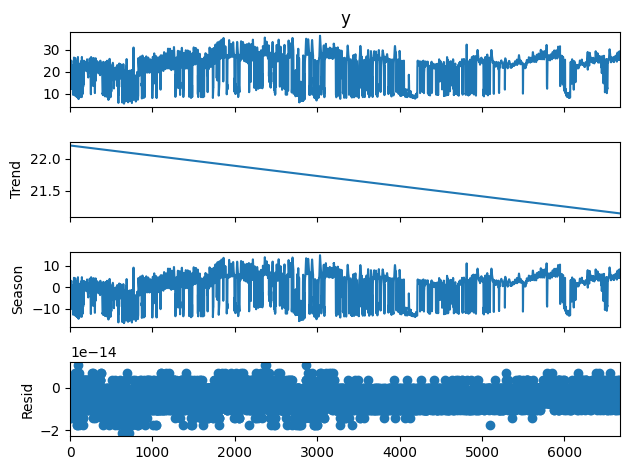

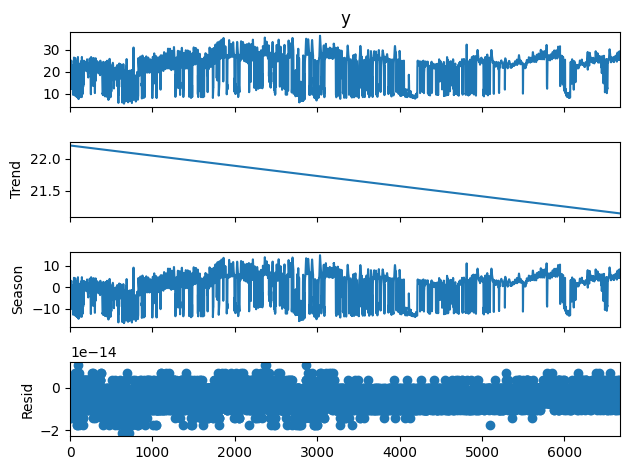

In [34]:
stl = STL(df1['y'],period=seasonal_period)
result=stl.fit()
result.plot()

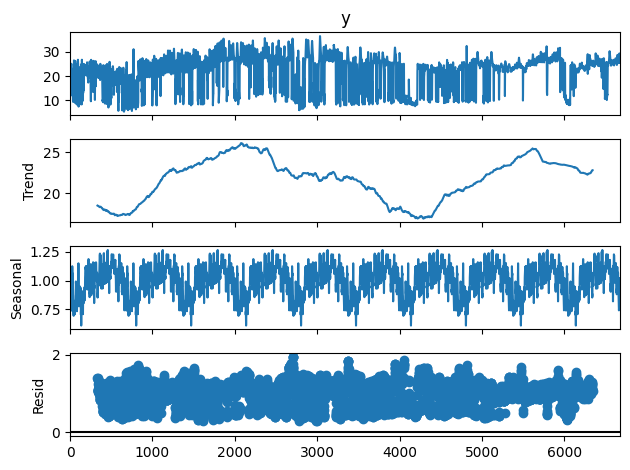

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
result2 = seasonal_decompose(df1['y'], model='multiplicative', period=seasonal_period)
result2.plot()
plt.show()

In [8]:
trend=result.trend
trend.head()
seasonal=result.seasonal

In [9]:
a=pd.DataFrame(trend)
a.shape

(6676, 1)

In [10]:
a['ds']=df1['ds']
a['unique_id']=df1['unique_id']
a['y']=a['trend']

In [11]:
a=a.dropna().reset_index(drop=True)
a.head()

,trend,ds,unique_id,y
0,19.671413,2022-01-04 00:00:00,h1,19.671413
1,19.667384,2022-01-04 01:00:00,h1,19.667384
2,19.663358,2022-01-04 02:00:00,h1,19.663358
3,19.659334,2022-01-04 03:00:00,h1,19.659334
4,19.655312,2022-01-04 04:00:00,h1,19.655312


In [12]:
a.shape

(6676, 4)

In [13]:
train=a[:5340]
test=a[5340:]
train.shape,test.shape

((5340, 4), (1336, 4))

In [14]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=500,max_depth=10,reg_lambda=0.2)
ftsc=MLForecast(
    models={
        'xgb':model,
        # 'prophet':ProphetWrapper(),
    },
    freq='H',
    lags=[168,30],
    lag_transforms={
        30:[(rolling_mean,30),(rolling_std,30),(rolling_min,30),(rolling_max,30)],
        168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    },
    target_transforms=[Differences([350])],
    date_features=['hour','day','weekday','month','year'],
)
ftsc.fit(train,id_col='unique_id',time_col='ds',target_col='y')
# min_child_weight=
# ,gamma=
# ,subsample=
# objective="reg:squarederror",

MLForecast(models=[xgb], freq=H, lag_features=['lag168', 'lag30', 'rolling_mean_lag30_window_size30', 'rolling_std_lag30_window_size30', 'rolling_min_lag30_window_size30', 'rolling_max_lag30_window_size30', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_min_lag168_window_size168', 'rolling_max_lag168_window_size168'], date_features=['hour', 'day', 'weekday', 'month', 'year'], num_threads=1)

In [15]:
preds=ftsc.predict(1336)
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-14 12:00:00,23.592926
1,h1,2022-08-14 13:00:00,23.600031
2,h1,2022-08-14 14:00:00,23.607129
3,h1,2022-08-14 15:00:00,23.609067
4,h1,2022-08-14 16:00:00,23.616154


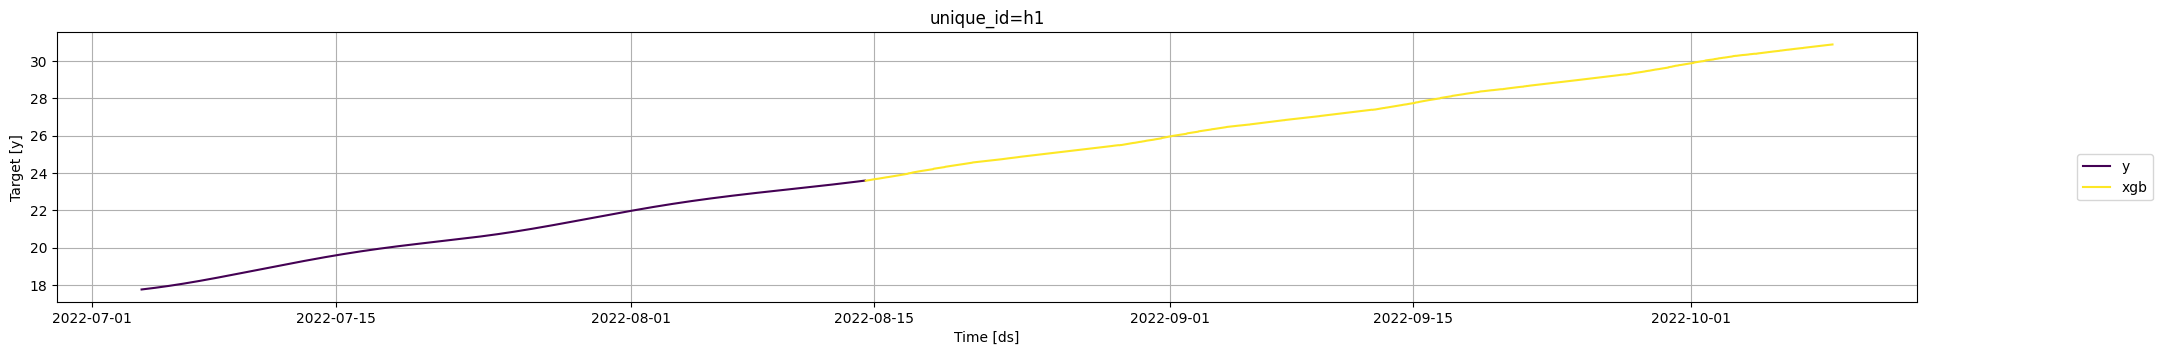

In [16]:
plot_series(train,preds,max_insample_length=1000)

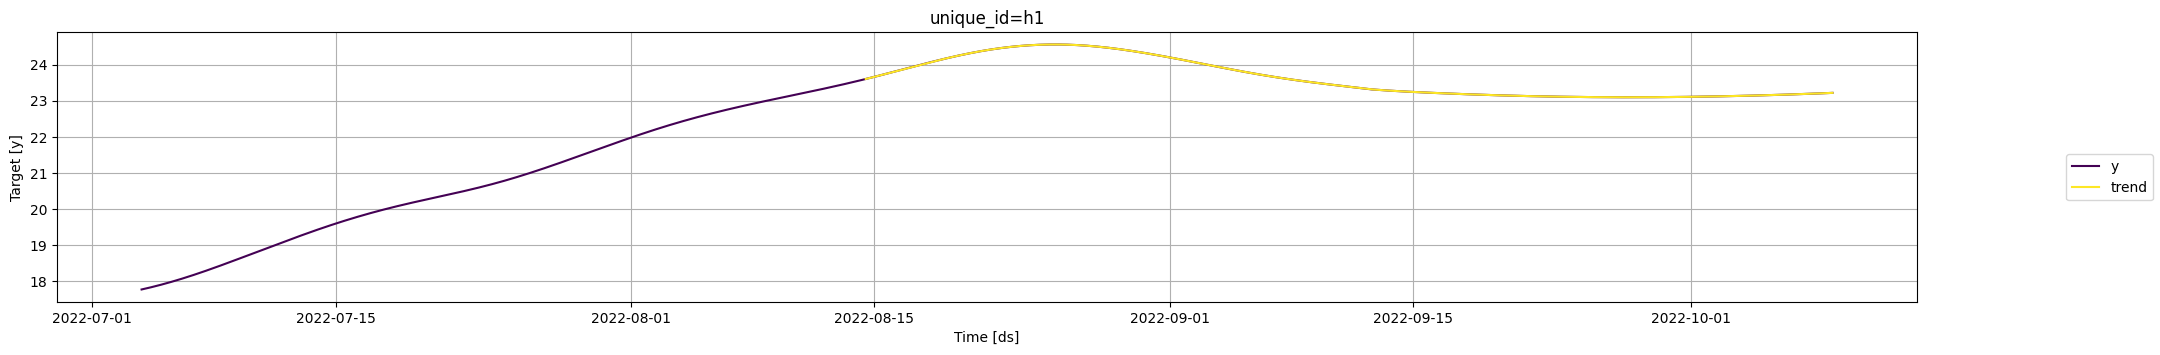

In [17]:
plot_series(train,test,max_insample_length=1000)

In [18]:
mse_test = mean_squared_error(test['y'], preds['xgb'])
mse_test

np.float64(20.027202663960953)